In [1]:
import collections
import itertools
import json
import os
import re
import glob
import operator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
def compute_accuracy(rows):
    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    total = collections.defaultdict(int)
    exact = collections.defaultdict(int)
    for row in rows:
        exact[row['hardness']] += row['exact']
        exact['all'] += row['exact']
        total[row['hardness']] += 1
        total['all'] += 1
    
    result = {hardness: exact[hardness] / total[hardness]
              for hardness in levels}
    result = {**result, **{'{} count'.format(hardness): total[hardness] for hardness in levels}}
    return result

In [25]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logs/*')):
    exp_name = os.path.basename(d)
    # exp_vars = re.match('maml.*', exp_name).groups()
    

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((exp_name,)+( len(eval_paths),) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('name', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))
df

../logs/maml-0926-test_meta
../logs/maml-1001-try_larger-wrongskip
../logs/maml-1001-try_maml
../logs/maml-1001-try_reptile
../logs/maml-1001-try_reptile-wrongskip
../logs/maml-1003-non_meta
../logs/test0
../logs/test1
../logs/test2


,name,num steps eval,step,acc,1/2 acc,2/2 acc
0,maml-0926-test_meta,0,-1,-1.000000,-1.000000,-1.000000
1,maml-1001-try_larger-wrongskip,8,10000,0.409091,0.417795,0.400387
2,maml-1001-try_maml,4,3100,0.340426,0.330754,0.350097
3,maml-1001-try_reptile,2,1100,0.318182,0.326886,0.309478
4,maml-1001-try_reptile-wrongskip,6,5100,0.372340,0.355899,0.388781
5,maml-1003-non_meta,9,10000,0.254352,0.280464,0.228240
6,test0,0,-1,-1.000000,-1.000000,-1.000000
7,test1,0,-1,-1.000000,-1.000000,-1.000000
8,test2,0,-1,-1.000000,-1.000000,-1.000000


In [17]:
df

,name,num steps eval,step,acc,1/2 acc,2/2 acc
0,0,-1,-1,-1.000000,-1.000000,NaN
1,8,maml-1001-try_larger-wrongskip,10000,0.409091,0.417795,0.400387
2,4,maml-1001-try_maml,3100,0.340426,0.330754,0.350097
3,2,maml-1001-try_reptile,1100,0.318182,0.326886,0.309478
4,6,maml-1001-try_reptile-wrongskip,6100,0.366538,0.359768,0.373308
5,9,maml-1003-non_meta,10000,0.254352,0.280464,0.228240
6,0,-1,-1,-1.000000,-1.000000,NaN
7,0,-1,-1,-1.000000,-1.000000,NaN
8,0,-1,-1,-1.000000,-1.000000,NaN


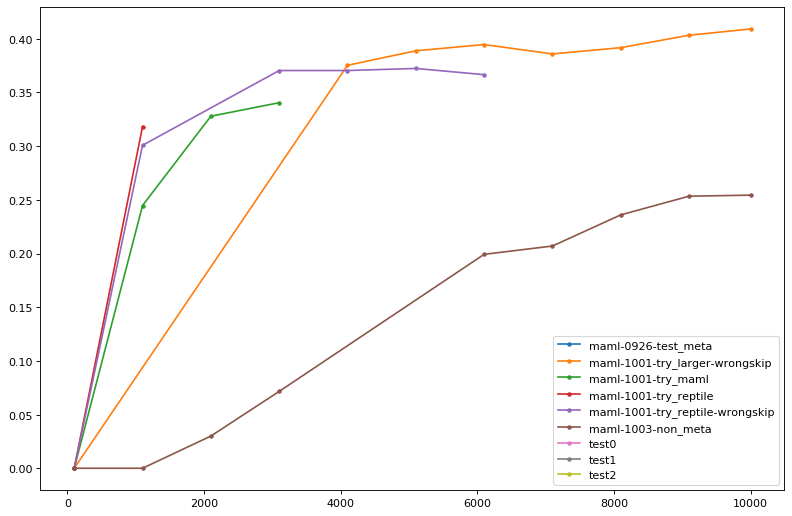

In [30]:
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()


In [20]:
dev = json.load(open('../data/spider-20190205/dev.json'))
def compare(data, left, right):
    both_exact = []
    left_exact = []
    right_exact = []
    neither_exact = []
    for i, (data_item, left_item, right_item) in enumerate(zip(data, left['per_item'], right['per_item'])):
        result = {
            'i': i,
            'db_id': data_item['db_id'],
            'question': data_item['question'],
            'gold': data_item['query'],
            'left': left_item['predicted'],
            'right': right_item['predicted'],
        }
        
        if left_item['exact'] and right_item['exact']:
            both_exact.append(result)
        elif left_item['exact']:
            left_exact.append(result)
        elif right_item['exact']:
            right_exact.append(result)
        else:
            neither_exact.append(result)
    return both_exact, left_exact, right_exact, neither_exact        

In [22]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-random/fixed=init,att=0/eval-val-step38100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-random/fixed=init,att=1/eval-val-step33100-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.27949709864603484, 0.09671179883945841, 0.08317214700193423)

In [23]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-random/fixed=data+model,att=0/eval-val-step37100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-random/fixed=data+model,att=1/eval-val-step40000-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.27852998065764023, 0.09090909090909091, 0.10348162475822051)

In [26]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=0/eval-val-step10100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=0/eval-val-step21100-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.3181818181818182, 0.08704061895551257, 0.08317214700193423)